In [1]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
from functools import reduce
import seaborn as sns
from typing import List

# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [2]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql import Window
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct, lag, lead, avg, count, unix_timestamp
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

MAX_MEMORY = '8G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 60000) \
        .set('spark.network.timeout', 60000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Lab_1_var_5") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()

directory_path = "data/"

file_list = [file for file in os.listdir(directory_path) if file.endswith(".csv")]

# Чтение файлов и создание DataFrame с явным указанием разделителя
dataframes = [spark.read.csv(os.path.join(directory_path, file), header=True, inferSchema=True, sep=';') for file in file_list]

# Объединение DataFrame в один
merged_dataframe = reduce(DataFrame.union, dataframes)

# Вывод первых строк объединенного DataFrame
merged_dataframe.limit(5).toPandas().head()

,timestamp,site_id,period_id,actual_consumption,actual_pv,load_00,load_01,load_02,load_03,load_04,...,pv_86,pv_87,pv_88,pv_89,pv_90,pv_91,pv_92,pv_93,pv_94,pv_95
0,2016-03-19 10:30:00,16,34,159.990084,1.912269,143.861074,139.368149,139.733305,145.722957,135.563121,...,3.697727,3.697734,3.697740,3.697745,3.697750,3.697755,3.697758,3.809936,3.809939,9.838237
1,2016-03-19 10:45:00,16,34,119.992563,8.295386,134.507290,144.440963,149.232412,131.016820,134.389858,...,3.697873,3.697863,3.697855,3.697848,3.697841,3.697835,3.810004,3.810000,9.838291,12.065509
2,2016-03-19 12:30:00,16,34,111.993059,99.026948,133.860285,138.849683,132.398214,132.391791,135.241348,...,3.810008,9.838298,12.065516,39.849600,50.795950,57.493067,75.089262,127.727624,131.243669,140.617869
3,2016-03-19 14:00:00,16,34,127.992067,183.464305,123.957616,129.463836,139.924336,127.390889,117.757496,...,75.090955,127.729126,131.245003,140.619054,145.892936,148.603865,167.915414,171.953602,186.377286,206.425585
4,2016-03-19 14:15:00,16,34,111.993059,218.446593,127.027236,142.284141,129.150072,115.478574,120.875351,...,127.730441,131.246170,140.620090,145.893856,148.604681,167.916139,171.954246,186.377857,206.426093,214.468607


In [3]:
merged_dataframe.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- site_id: integer (nullable = true)
 |-- period_id: integer (nullable = true)
 |-- actual_consumption: double (nullable = true)
 |-- actual_pv: double (nullable = true)
 |-- load_00: double (nullable = true)
 |-- load_01: double (nullable = true)
 |-- load_02: double (nullable = true)
 |-- load_03: double (nullable = true)
 |-- load_04: double (nullable = true)
 |-- load_05: double (nullable = true)
 |-- load_06: double (nullable = true)
 |-- load_07: double (nullable = true)
 |-- load_08: double (nullable = true)
 |-- load_09: double (nullable = true)
 |-- load_10: double (nullable = true)
 |-- load_11: double (nullable = true)
 |-- load_12: double (nullable = true)
 |-- load_13: double (nullable = true)
 |-- load_14: double (nullable = true)
 |-- load_15: double (nullable = true)
 |-- load_16: double (nullable = true)
 |-- load_17: double (nullable = true)
 |-- load_18: double (nullable = true)
 |-- load_19: double (nullable = true

Столбцы load_XX - показатели прогноза нагрузки потребления за каждые 15 минут, а pv_XX - прогноз произведенного фотоэлектричества на каждые 15 минут

In [4]:
merged_dataframe = merged_dataframe.select('timestamp', 'site_id', 'period_id', 
                                           'actual_consumption', 'actual_pv', 
                                           'load_00', 'load_19', 'load_38', 'load_57', 'load_76', 'load_95', 
                                           'pv_00', 'pv_19', 'pv_38', 'pv_57', 'pv_76', 'pv_95')

In [5]:
merged_dataframe.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- site_id: integer (nullable = true)
 |-- period_id: integer (nullable = true)
 |-- actual_consumption: double (nullable = true)
 |-- actual_pv: double (nullable = true)
 |-- load_00: double (nullable = true)
 |-- load_19: double (nullable = true)
 |-- load_38: double (nullable = true)
 |-- load_57: double (nullable = true)
 |-- load_76: double (nullable = true)
 |-- load_95: double (nullable = true)
 |-- pv_00: double (nullable = true)
 |-- pv_19: double (nullable = true)
 |-- pv_38: double (nullable = true)
 |-- pv_57: double (nullable = true)
 |-- pv_76: double (nullable = true)
 |-- pv_95: double (nullable = true)



In [6]:
# Вывод количества строк до удаления пустых значений
merged_dataframe.count()

914125

In [7]:
# Вывод количества уникальных значений
merged_dataframe.agg(*(countDistinct(col(c)).alias(c) for c in merged_dataframe.columns)).show()

+---------+-------+---------+------------------+---------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+
|timestamp|site_id|period_id|actual_consumption|actual_pv|load_00|load_19|load_38|load_57|load_76|load_95| pv_00| pv_19| pv_38| pv_57| pv_76| pv_95|
+---------+-------+---------+------------------+---------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+
|    80621|     15|      115|            192133|   443529| 897295| 903447| 905181| 900598| 886156| 865070|496098|664689|811154|762861|615561|479807|
+---------+-------+---------+------------------+---------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+



In [8]:
# Удаление строк с пропущенными значениями
cleaned_dataframe = merged_dataframe.dropna()

# Вывод количество строк после удаления пустых значений
cleaned_dataframe.count()

914125

In [9]:
# Расчет статистических показателей
statistics_summary = cleaned_dataframe.describe()
# Вывод сводной статистики
statistics_summary.toPandas()

,summary,site_id,period_id,actual_consumption,actual_pv,load_00,load_19,load_38,load_57,load_76,load_95,pv_00,pv_19,pv_38,pv_57,pv_76,pv_95
0,count,914125,914125,914125,914125,914125,914125,914125,914125,914125,914125,914125,914125,914125,914125,914125,914125
1,mean,22.6049719677287,45.51037987146178,148.91343101832587,112.90172012746065,149.04828691358992,149.51919896078246,149.4332195774401,149.36518484642266,149.32412076445254,149.30465913580645,112.25803487730244,111.77288636425851,111.64791221260056,111.58283482053834,111.50968359476654,111.55458487046262
2,stddev,4.303680898124877,27.32754343962616,88.46807012190563,306.19254238926425,84.76868889863732,76.05515039292106,75.69557039703909,75.67608873283204,75.68886911373875,75.68102799648207,299.47672717751124,289.5818614705614,289.2176343603221,289.05821303507963,288.9725585997834,288.99269427133976
3,min,16,0,0.03365931909114189,0.0,-1457.5318647036945,-616.4660170018908,-214.5262650643704,-54.26426155996367,-26.823037551232947,-26.13249442993074,-794.7447205522094,-598.8022791256082,-372.4889114393399,-85.368085170773,-58.19211334116961,-40.82480334469958
4,max,30,114,3193.2644229865437,4102.021236361368,2469.256235423116,1862.6448746530268,1874.5674756473,1879.4655093135716,1880.9033354309413,1882.01744291954,4644.918647598194,3910.3960141431385,3807.653648685541,3807.6530105626516,3807.653001801597,3807.6530044049787


## Выводы по сводной статистике:

site_id: Среднее значение около 22.6, с отклонением приблизительно 4.30. Это категориальный признак, и судя по стандартному отклонению, можно сказать, что уровни site_id варьируются в пределах одной категории.

period_id: Среднее значение около 45.51, с отклонением приблизительно 27.32. Аналогично site_id, period_id также является категориальным признаком с несколькими уровнями.

actual_consumption: Среднее значение около 149.91, со стандартным отклонением около 88.46. Минимальное значение 0.03, а максимальное - 3193.26. Большое стандартное отклонение свидетельствует о том, что есть значительные различия в потреблении энергии в разные периоды времени.

actual_pv: Среднее значение около 111.90, со стандартным отклонением около 306.19. Этот признак также представляет собой потребление энергии, с очень широким разбросом.

load_00, load_19, load_38, load_57, load_76, load_95: Все эти признаки кажутся похожими, причем у них высокие средние значения и стандартные отклонения, что может свидетельствовать о значительных колебаниях.

pv_00, pv_19, pv_38, pv_57, pv_76, pv_95: Аналогично признакам load, эти признаки также имеют высокие средние значения и стандартные отклонения.

О period_id. Некоторые признаки имеют значительные колебания и могут содержать выбросы, что требует дополнительного анализа и обработки данных перед использованием их в моделировании. аномалии.

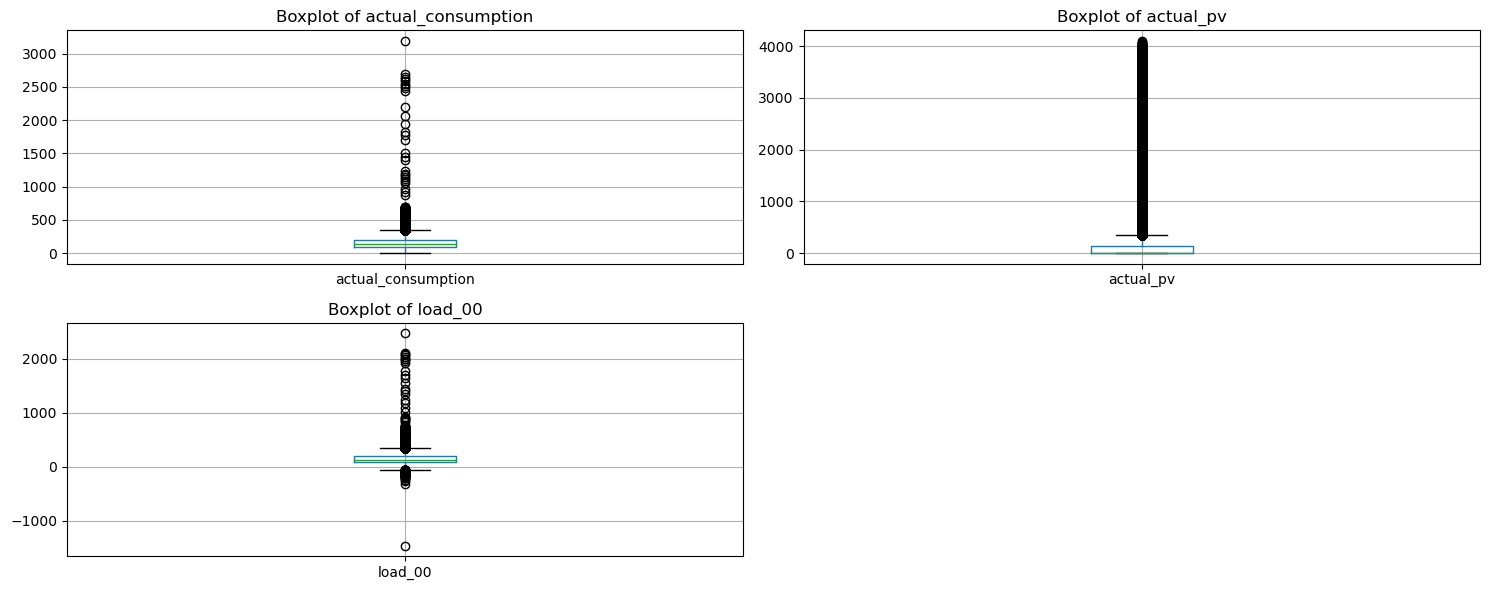

In [10]:
def print_columns_box_plotes(dataframe: DataFrame, columns_to_print: List[str], number_of_cols: int = 2) -> None:
    # Определение количества строк и столбцов для Subplots
    num_rows = len(columns_to_print) // number_of_cols + (len(columns_to_print) % number_of_cols > 0)
    fig, axs = plt.subplots(num_rows, number_of_cols, figsize=(15, 3 * num_rows))

    for i, column in enumerate(columns_to_print):
        # Преобразование PySpark DataFrame в Pandas DataFrame
        pandas_df = dataframe.select(column).toPandas()
        # Построение boxplot
        pandas_df.boxplot(column=column, ax=axs[i // number_of_cols, i % number_of_cols])
        axs[i // number_of_cols, i % number_of_cols].set_title(f'Boxplot of {column}')

    # Убираем пустые подграфики, если количество не кратно number_of_cols
    for i in range(len(columns_to_print), num_rows * number_of_cols):
        fig.delaxes(axs.flatten()[i])

    # Регулировка расположения подграфиков
    plt.tight_layout()

    # Отображение графика
    plt.show()
columns_to_filter = ['actual_consumption', 'actual_pv', 'load_00']
print_columns_box_plotes(cleaned_dataframe, columns_to_filter)

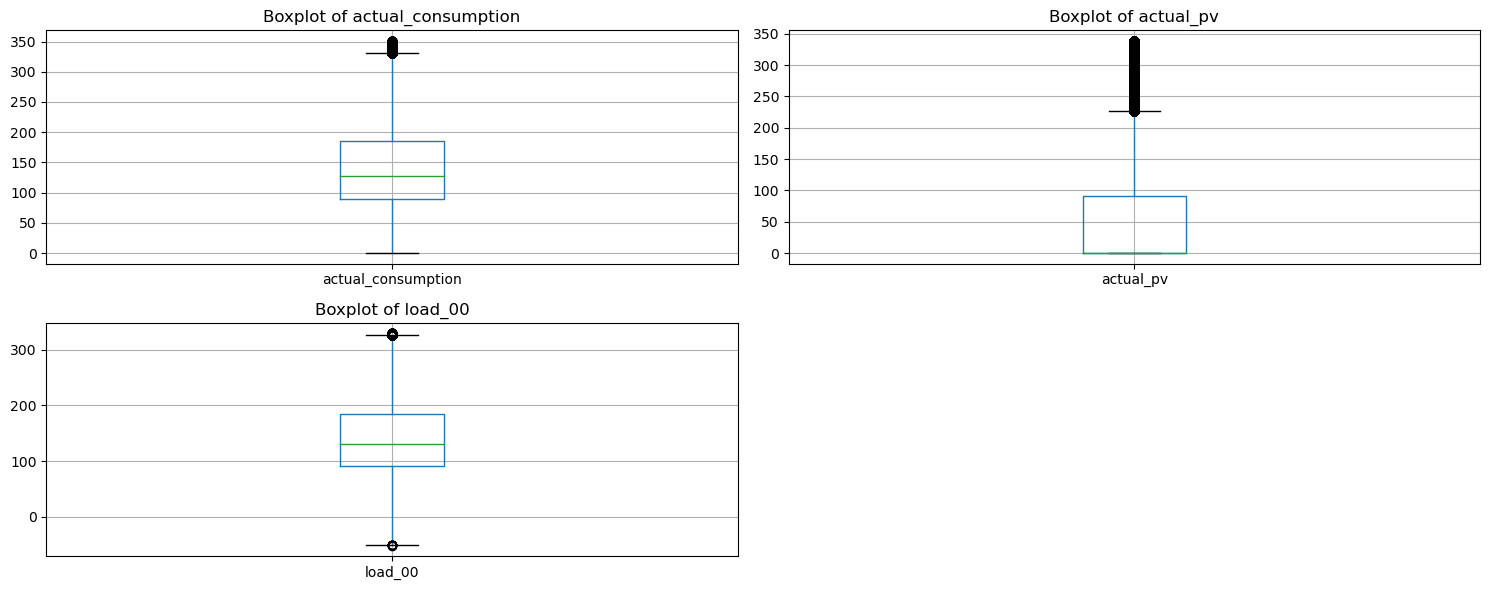

In [11]:
# Фильтрация выбросов для каждого столбца
for column in columns_to_filter:
    # Рассчет квартилей
    quartiles = cleaned_dataframe.stat.approxQuantile(column, [0.25, 0.75], 0.0)

    # Рассчет межквартильного размаха
    IQR = quartiles[1] - quartiles[0]

    # Определение границ для определения выбросов
    lower_bound = quartiles[0] - 1.5 * IQR
    upper_bound = quartiles[1] + 1.5 * IQR

    # Фильтрация данных
    cleaned_dataframe = cleaned_dataframe.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

print_columns_box_plotes(cleaned_dataframe, columns_to_filter)

Гистограммы распределения количественных признаков

(array([23073., 12933., 12905., 11673., 21341., 35962., 55521., 54680.,
        60852., 63643., 64501., 43408., 47043., 41651., 35578., 38388.,
        33457., 29944., 22622., 20528., 16767., 15259., 13153., 12075.,
        10919., 10528.,  7966.,  5127.,  2620.,  1129.]),
 array([3.36593191e-02, 1.17317325e+01, 2.34298057e+01, 3.51278789e+01,
        4.68259521e+01, 5.85240253e+01, 7.02220985e+01, 8.19201717e+01,
        9.36182449e+01, 1.05316318e+02, 1.17014391e+02, 1.28712464e+02,
        1.40410538e+02, 1.52108611e+02, 1.63806684e+02, 1.75504757e+02,
        1.87202830e+02, 1.98900904e+02, 2.10598977e+02, 2.22297050e+02,
        2.33995123e+02, 2.45693196e+02, 2.57391270e+02, 2.69089343e+02,
        2.80787416e+02, 2.92485489e+02, 3.04183562e+02, 3.15881636e+02,
        3.27579709e+02, 3.39277782e+02, 3.50975855e+02]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Distribution of actual_consumption')

Text(0.5, 0, 'actual_consumption')

Text(0, 0.5, 'Frequency')

(array([500877.,  23995.,  19915.,  17514.,  15771.,  14459.,  13405.,
         12443.,  11875.,  11392.,  10828.,  10726.,  10359.,  10215.,
         10317.,  10377.,  10443.,  10426.,  10245.,  10399.,   9854.,
          9551.,   8949.,   8524.,   8133.,   7590.,   7409.,   6981.,
          6396.,   5878.]),
 array([  0.        ,  11.28939047,  22.57878094,  33.86817141,
         45.15756187,  56.44695234,  67.73634281,  79.02573328,
         90.31512375, 101.60451422, 112.89390468, 124.18329515,
        135.47268562, 146.76207609, 158.05146656, 169.34085703,
        180.63024749, 191.91963796, 203.20902843, 214.4984189 ,
        225.78780937, 237.07719984, 248.3665903 , 259.65598077,
        270.94537124, 282.23476171, 293.52415218, 304.81354265,
        316.10293311, 327.39232358, 338.68171405]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Distribution of actual_pv')

Text(0.5, 0, 'actual_pv')

Text(0, 0.5, 'Frequency')

(array([   82.,    95.,   229.,   479., 18301., 10068., 15320., 12950.,
        27199., 43749., 64909., 60940., 64504., 73563., 59984., 48503.,
        46690., 44956., 40996., 37770., 30195., 24276., 19945., 16717.,
        14905., 12753., 11655., 10441.,  7649.,  5423.]),
 array([-51.97429682, -39.25376192, -26.53322703, -13.81269214,
         -1.09215724,  11.62837765,  24.34891254,  37.06944744,
         49.78998233,  62.51051722,  75.23105212,  87.95158701,
        100.6721219 , 113.3926568 , 126.11319169, 138.83372658,
        151.55426148, 164.27479637, 176.99533126, 189.71586616,
        202.43640105, 215.15693594, 227.87747083, 240.59800573,
        253.31854062, 266.03907551, 278.75961041, 291.4801453 ,
        304.20068019, 316.92121509, 329.64174998]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Distribution of load_00')

Text(0.5, 0, 'load_00')

Text(0, 0.5, 'Frequency')

(array([3.27760e+04, 1.97049e+05, 3.11835e+05, 1.93919e+05, 6.85690e+04,
        1.90910e+04, 1.63200e+03, 3.48000e+02, 2.40000e+01, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 2.00000e+00]),
 array([ -26.13249443,   37.47250348,  101.07750139,  164.68249931,
         228.28749722,  291.89249513,  355.49749304,  419.10249095,
         482.70748886,  546.31248677,  609.91748469,  673.5224826 ,
         737.12748051,  800.73247842,  864.33747633,  927.94247424,
         991.54747216, 1055.15247007, 1118.75746798, 1182.36246589,
        1245.9674638 , 1309.57246171, 1373.17745963, 1436.78245754,
        1500.38745545, 1563.99245336, 1627.59745127, 1691.20244918,
        1754.8074471 , 1818.41244501, 1882.01744292]),
 <BarContainer object of 30 a

Text(0.5, 1.0, 'Distribution of load_95')

Text(0.5, 0, 'load_95')

Text(0, 0.5, 'Frequency')

(array([2.00000e+00, 1.00000e+00, 1.00000e+00, 4.00000e+00, 3.00000e+00,
        8.00000e+00, 2.90000e+01, 5.80000e+01, 3.19000e+02, 5.25078e+05,
        1.12456e+05, 8.32230e+04, 7.04320e+04, 3.17150e+04, 1.48500e+03,
        2.32000e+02, 8.80000e+01, 4.10000e+01, 2.50000e+01, 1.60000e+01,
        1.30000e+01, 5.00000e+00, 3.00000e+00, 2.00000e+00, 3.00000e+00,
        1.00000e+00, 0.00000e+00, 2.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([-794.74472055, -712.32359022, -629.90245989, -547.48132956,
        -465.06019923, -382.63906891, -300.21793858, -217.79680825,
        -135.37567792,  -52.95454759,   29.46658274,  111.88771307,
         194.3088434 ,  276.72997373,  359.15110406,  441.57223439,
         523.99336472,  606.41449505,  688.83562538,  771.25675571,
         853.67788604,  936.09901637, 1018.52014669, 1100.94127702,
        1183.36240735, 1265.78353768, 1348.20466801, 1430.62579834,
        1513.04692867, 1595.468059  , 1677.88918933]),
 <BarContainer object of 30 a

Text(0.5, 1.0, 'Distribution of pv_00')

Text(0.5, 0, 'pv_00')

Text(0, 0.5, 'Frequency')

(array([5.98455e+05, 1.39722e+05, 7.51570e+04, 9.81300e+03, 1.38000e+03,
        2.36000e+02, 8.20000e+01, 5.30000e+01, 5.60000e+01, 2.10000e+01,
        4.00000e+01, 2.60000e+01, 2.80000e+01, 2.30000e+01, 2.60000e+01,
        1.80000e+01, 2.90000e+01, 1.40000e+01, 1.90000e+01, 7.00000e+00,
        9.00000e+00, 3.00000e+00, 6.00000e+00, 5.00000e+00, 3.00000e+00,
        7.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00, 6.00000e+00]),
 array([ -40.82480334,   85.42885488,  211.68251311,  337.93617133,
         464.18982956,  590.44348778,  716.69714601,  842.95080423,
         969.20446246, 1095.45812068, 1221.71177891, 1347.96543714,
        1474.21909536, 1600.47275359, 1726.72641181, 1852.98007004,
        1979.23372826, 2105.48738649, 2231.74104471, 2357.99470294,
        2484.24836116, 2610.50201939, 2736.75567762, 2863.00933584,
        2989.26299407, 3115.51665229, 3241.77031052, 3368.02396874,
        3494.27762697, 3620.53128519, 3746.78494342]),
 <BarContainer object of 30 a

Text(0.5, 1.0, 'Distribution of pv_95')

Text(0.5, 0, 'pv_95')

Text(0, 0.5, 'Frequency')

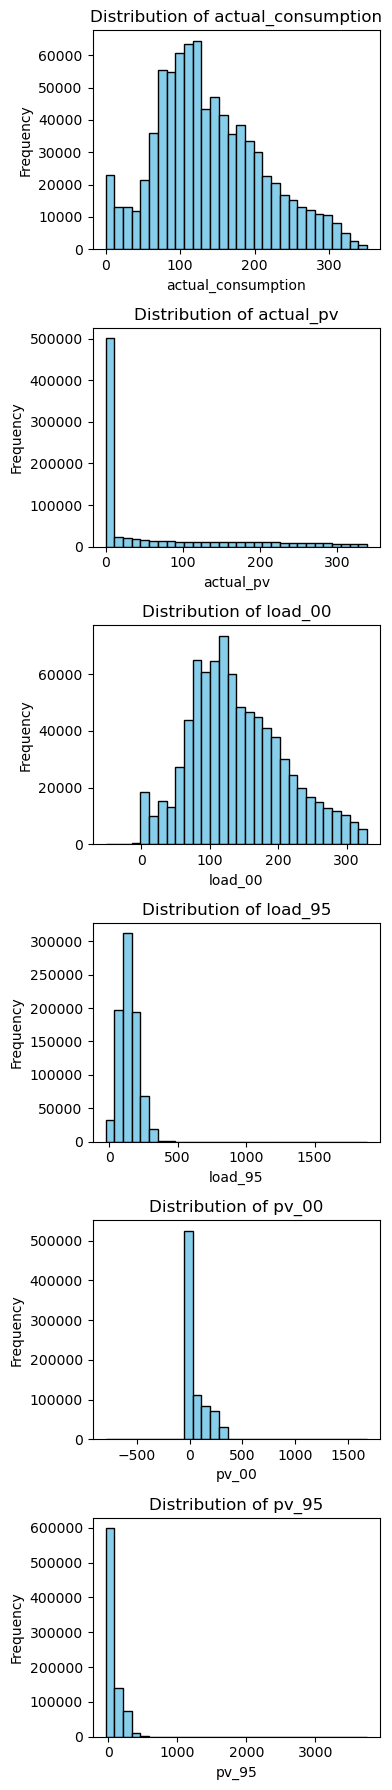

In [12]:
selected_features = ['actual_consumption', 'actual_pv', 'load_00', 'load_95', 'pv_00', 'pv_95'] 
fig, axs = plt.subplots(len(selected_features), 1, figsize=(4, 3 * len(selected_features)))

# Построение гистограмм для каждого выбранного признака
for i, feature in enumerate(selected_features):
    # Преобразование PySpark DataFrame в Pandas DataFrame
    pandas_data = cleaned_dataframe.select(feature).toPandas()
    # Построение гистограммы
    axs[i].hist(pandas_data[feature], bins=30, color='skyblue', edgecolor='black')
    axs[i].set_title(f'Distribution of {feature}')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Frequency')

# Регулировка расположения подграфиков
plt.tight_layout()

# Отображение графика
plt.show()

Гистограммы распределения категориальных признаков

<BarContainer object of 15 artists>

Text(0.5, 1.0, 'Distribution of site_id')

Text(0.5, 0, 'site_id')

Text(0, 0.5, 'Count')

<BarContainer object of 115 artists>

Text(0.5, 1.0, 'Distribution of period_id')

Text(0.5, 0, 'period_id')

Text(0, 0.5, 'Count')

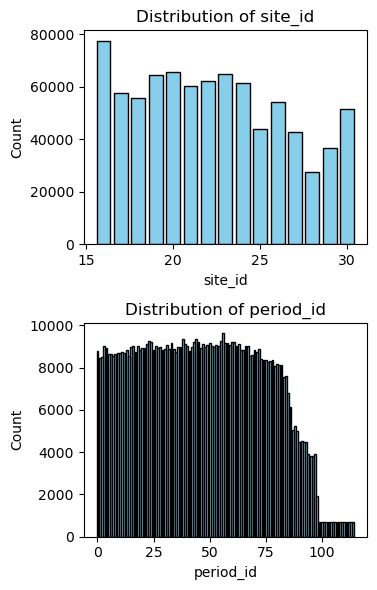

In [13]:
selected_features = ['site_id', 'period_id'] 

fig, axs = plt.subplots(len(selected_features), 1, figsize=(4, 3 * len(selected_features)))

# Построение гистограмм для каждого выбранного признака
for i, feature in enumerate(selected_features):
    # Сгруппировать по признаку и подсчитать количество
    data_grouped = cleaned_dataframe.groupBy(feature).count().collect()
    # Извлечение данных для построения графика
    categories = [row[0] for row in data_grouped]
    counts = [row[1] for row in data_grouped]
    axs[i].bar(categories, counts, color='skyblue', edgecolor='black')
    axs[i].set_title(f'Distribution of {feature}')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Count')

# Регулировка расположения подграфиков
plt.tight_layout()

# Отображение графика
plt.show()

In [14]:
# Создаем VectorAssembler для объединения признаков в один вектор
feature_cols = ['load_00', 'load_19', 'load_38', 'load_57', 'load_76', 'load_95', 'pv_00', 'pv_19', 'pv_38', 'pv_57', 'pv_76', 'pv_95']  
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Применяем VectorAssembler к данным
data = vector_assembler.transform(cleaned_dataframe)

# Вычисляем матрицу корреляции
correlation_matrix = Correlation.corr(data, "features").head()
correlation_array = correlation_matrix[0].toArray()

# Выводим матрицу корреляции
correlation_df = pd.DataFrame(correlation_array, columns=feature_cols)

In [15]:
correlation_df.corr()

,load_00,load_19,load_38,load_57,load_76,load_95,pv_00,pv_19,pv_38,pv_57,pv_76,pv_95
load_00,1.000000,0.658574,0.242034,0.255355,0.674111,0.971387,0.281200,-0.359497,-0.659868,-0.613140,-0.271250,0.231993
load_19,0.658574,1.000000,0.697963,0.275474,0.297611,0.631441,0.052743,0.128234,-0.162254,-0.641013,-0.666393,-0.035490
load_38,0.242034,0.697963,1.000000,0.705519,0.328729,0.236687,-0.501863,0.020665,0.213732,-0.089078,-0.524044,-0.560029
load_57,0.255355,0.275474,0.705519,1.000000,0.740977,0.299263,-0.645097,-0.464308,-0.067419,0.222146,0.022764,-0.637813
load_76,0.674111,0.297611,0.328729,0.740977,1.000000,0.739611,-0.168128,-0.668581,-0.564007,-0.136649,0.096404,-0.155945
load_95,0.971387,0.631441,0.236687,0.299263,0.739611,1.000000,0.283461,-0.395690,-0.690012,-0.612556,-0.249345,0.240816
pv_00,0.281200,0.052743,-0.501863,-0.645097,-0.168128,0.283461,1.000000,-0.009133,-0.584505,-0.660453,-0.139040,0.969491
pv_19,-0.359497,0.128234,0.020665,-0.464308,-0.668581,-0.395690,-0.009133,1.000000,0.621438,-0.261060,-0.553705,-0.077979
pv_38,-0.659868,-0.162254,0.213732,-0.067419,-0.564007,-0.690012,-0.584505,0.621438,1.000000,0.444333,-0.280059,-0.608618
pv_57,-0.613140,-0.641013,-0.089078,0.222146,-0.136649,-0.612556,-0.660453,-0.261060,0.444333,1.000000,0.603556,-0.595232


<Figure size 1200x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Матрица корреляции признаков')

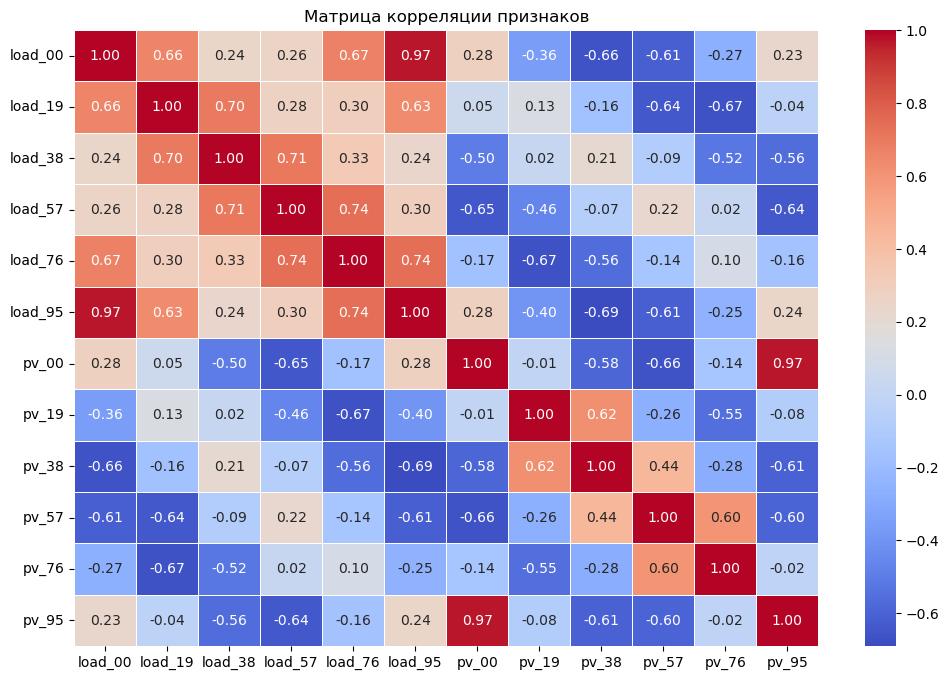

In [16]:
# Строим тепловую карту корреляции с использованием Seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Матрица корреляции признаков')
plt.show()

In [17]:
# Определяем окно сортировки по полю 'timestamp'
windowSpec = Window.orderBy(desc("timestamp"))

# Добавляем столбцы с лагами и лидами для 'load_00'
data_with_lag_lead = cleaned_dataframe.withColumn("lag_load_00", lag("load_00").over(windowSpec)) \
                            .withColumn("lead_load_00", lead("load_00").over(windowSpec))

# Группируем данные по 'timestamp' и аггрегируем с использованием desc сортировки
last_three_timestamps = data_with_lag_lead.groupBy("timestamp") \
                                          .agg(count("timestamp").alias("count")) \
                                          .orderBy(desc("timestamp")) \
                                          .limit(3)

# Присоединяем последние три метки времени к данным
latest_rows = data_with_lag_lead.join(last_three_timestamps, "timestamp")

result = latest_rows.withColumn("avg_load_00", (col("lag_load_00") + col("lead_load_00") + col("load_00")) / 3) \
                          .select("timestamp", "load_00", "lag_load_00", "lead_load_00", "avg_load_00")

# Выводим результат
result.show()

+-------------------+------------------+------------------+------------------+------------------+
|          timestamp|           load_00|       lag_load_00|      lead_load_00|       avg_load_00|
+-------------------+------------------+------------------+------------------+------------------+
|2017-11-06 22:00:00|156.93477416326627|              NULL|147.73684170541654|              NULL|
|2017-11-06 21:45:00|147.73684170541654|156.93477416326627| 161.7023801150484|155.45799866124375|
|2017-11-06 21:30:00| 161.7023801150484|147.73684170541654| 164.5088977956839| 157.9827065387163|
+-------------------+------------------+------------------+------------------+------------------+



In [18]:
# Сохраним преобразованный датафрейм в csv-файл.
cleaned_dataframe.coalesce(1).write.mode('overwrite').options(header='True', delimiter=';').csv('filtered_data/data')
# Закрываем сессию Spark
spark.stop()